<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/MultiModel_images_food_101_ResNet_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# sudo fuser -v /dev/nvidia* # Use it to check the status of VM
# nvidia-smi # Use it to check the GPU/Memory Allocation/Utilization
# kill -9 pid # Use it to forecefully terminate the processes on the GPU

# At 4:00 17 epoches

In [ ]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# Mount Drive

In [18]:
# !gdown  https://drive.google.com/uc?id=1Lb5wajGmH0u4L05n1jtLf2VkH2rWf-Li

Downloading...
From: https://drive.google.com/uc?id=1Lb5wajGmH0u4L05n1jtLf2VkH2rWf-Li
To: /content/test.zip
100% 2.81G/2.81G [00:21<00:00, 128MB/s]


# Extract Images

In [19]:
import zipfile

zip_path = '/content/test.zip'
extract_path = '/content/Data/'

In [20]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# path = "/content/multi_model-images-val.rar"

In [ ]:
# patoolib.extract_archive(path, outdir="/content/Data/" )

# Loading Training Dataset and Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class FragmentaDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()
        self.num_classes = len(self.dataset.classes)

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    # def __getitem__(self, index):
    #     image, label = self.dataset[index]
    #     return image, label

    def __getitem__(self, index):
        while True:
            try:
                image, label = self.dataset[index]
                return image, label
            except (UnidentifiedImageError, FileNotFoundError) as e:
                print(f"Error loading image at index {index}: {e}")
                index += 1

    def __len__(self):
        return len(self.dataset)

    def get_num_classes(self):
        return self.num_classes

In [ ]:
data_dir = "/content/Data/Food-101-train"
dataset = FragmentaDataset(data_dir)

In [ ]:
print("Number of samples:", len(dataset))
print("Number of classes:", len(dataset.classes))

Number of samples: 203964
Number of classes: 101


In [ ]:
batch_size = 16
num_workers = 2
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# EDA

In [ ]:
class_length = dataset.class_lengths
class_labels = list(class_length.keys())

In [ ]:
from torchvision.transforms import ToPILImage

def plot_sample_images(dataset):


    # Create a grid layout based on the number of classes
    num_classes = len(class_length)
    grid_cols = 4  # Number of columns in the grid
    grid_rows = (num_classes + grid_cols - 1) // grid_cols  # Number of rows in the grid
    plt.figure(figsize=(10, 5 * grid_rows))

    # Create a transform to convert the tensor to PIL Image
    to_pil = ToPILImage()

    # Iterate over each class
    for i, class_label in enumerate(class_labels):
        # Get a random image index from the class
        image_index = np.random.choice(class_length[class_label])

        # Get the image and label from the dataset
        image, label = dataset[image_index]

        # Convert the image tensor to PIL Image
        image = to_pil(image)

        # Plot the image
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(image, interpolation='none')  # Use 'RGB' interpolation
        plt.title(class_label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
plot_sample_images(dataset)

In [ ]:
class_lengths_dict = dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

In [ ]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Create a count plot
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=class_counts)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class')
plt.show()

In [ ]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Sort the class labels and counts in ascending order
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k])
class_labels_sorted = [class_labels[i] for i in sorted_indices]
class_counts_sorted = [class_counts[i] for i in sorted_indices]

# Create a count plot with sorted data
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels_sorted, y=class_counts_sorted)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class (Ascending Order)')
plt.show()


# Loading ResNet-101

In [ ]:
num_classes = dataset.get_num_classes()
print("Number of classes:", num_classes)

Number of classes: 101


In [ ]:
import torchvision


In [ ]:
resnet = torchvision.models.resnet101(pretrained=True)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)  # 101 is the number of classes in your dataset
resnet.to(device)
print(resnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Fine Tuning

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
num_epochs = 25

In [14]:
training_loss = []
resnet.train()

for epoch in range(num_epochs):
    # Set the model to training mode
    running_loss = 0.0

    # Iterate over the data loader
    for images, labels in data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * images.size(0)

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(data_loader.dataset)
    training_loss.append(epoch_loss)
    # Print the epoch loss
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

Epoch 1/25 Loss: 1.3797
Epoch 2/25 Loss: 0.3368
Epoch 3/25 Loss: 0.1688
Epoch 4/25 Loss: 0.0951
Epoch 5/25 Loss: 0.0584
Epoch 6/25 Loss: 0.0425
Epoch 7/25 Loss: 0.0301
Epoch 8/25 Loss: 0.0245
Epoch 9/25 Loss: 0.0176
Epoch 10/25 Loss: 0.0156
Epoch 11/25 Loss: 0.0131
Epoch 12/25 Loss: 0.0117
Epoch 13/25 Loss: 0.0101
Epoch 14/25 Loss: 0.0086
Epoch 15/25 Loss: 0.0081
Epoch 16/25 Loss: 0.0078
Epoch 17/25 Loss: 0.0073
Epoch 18/25 Loss: 0.0071
Epoch 19/25 Loss: 0.0070
Epoch 20/25 Loss: 0.0070
Epoch 21/25 Loss: 0.0067
Epoch 22/25 Loss: 0.0064
Epoch 23/25 Loss: 0.0063
Epoch 24/25 Loss: 0.0059
Epoch 25/25 Loss: 0.0060


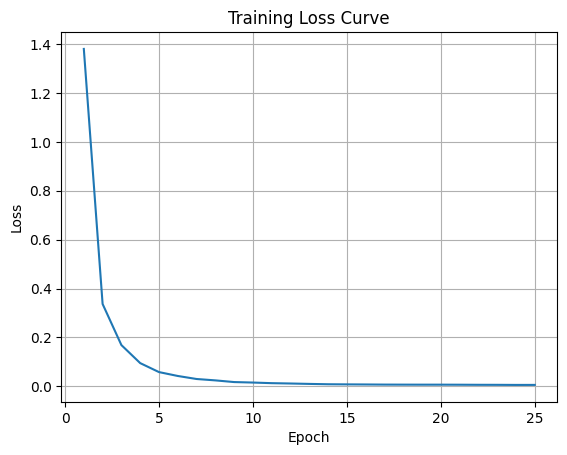

In [15]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# Save Model

In [21]:
save_dir = "/content/Model/ResNet_MultiModel_Food101/"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

save_path = os.path.join(save_dir, 'model.pth')  # Specify the complete path to the model file
torch.save(resnet.state_dict(), save_path)

# Loading Validation Dataset and Preprocessing

In [ ]:
# save_dir = '/content/drive/MyDrive/Colab Notebooks/ferramenta/models'
# load_path = os.path.join(save_dir, 'model.pth')

# # Create an instance of the ResNet model
# resnet = models.resnet50(pretrained=False)
# resnet.fc = nn.Linear(2048, 52)

# # Load the saved model parameters
# resnet.load_state_dict(torch.load(load_path))

# # Set the model to evaluation mode and respective device
# resnet.eval()
# resnet.to(device)

In [22]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [23]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=val_transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

In [24]:
valPath = "/content/Data/Food-101-test-Fused"
val_dataset = ValidationDataset(valPath)

In [25]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 22716
Number of classes: 101


In [26]:
batch_size = 32
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [27]:
class_lengths_dict = val_dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

Dictionary length: 101
Total sum: 22716
dict_values([234, 221, 226, 222, 225, 224, 224, 225, 226, 214, 231, 227, 230, 220, 231, 227, 224, 233, 222, 220, 219, 232, 224, 230, 224, 220, 221, 225, 224, 228, 229, 232, 228, 231, 213, 202, 228, 212, 208, 216, 212, 223, 238, 212, 229, 233, 224, 234, 223, 229, 225, 228, 232, 233, 203, 234, 223, 234, 232, 233, 197, 215, 238, 231, 227, 234, 224, 231, 217, 223, 230, 228, 234, 225, 211, 218, 235, 227, 210, 220, 224, 232, 236, 227, 236, 215, 226, 228, 219, 228, 213, 218, 230, 229, 223, 237, 233, 223, 232, 211, 235])


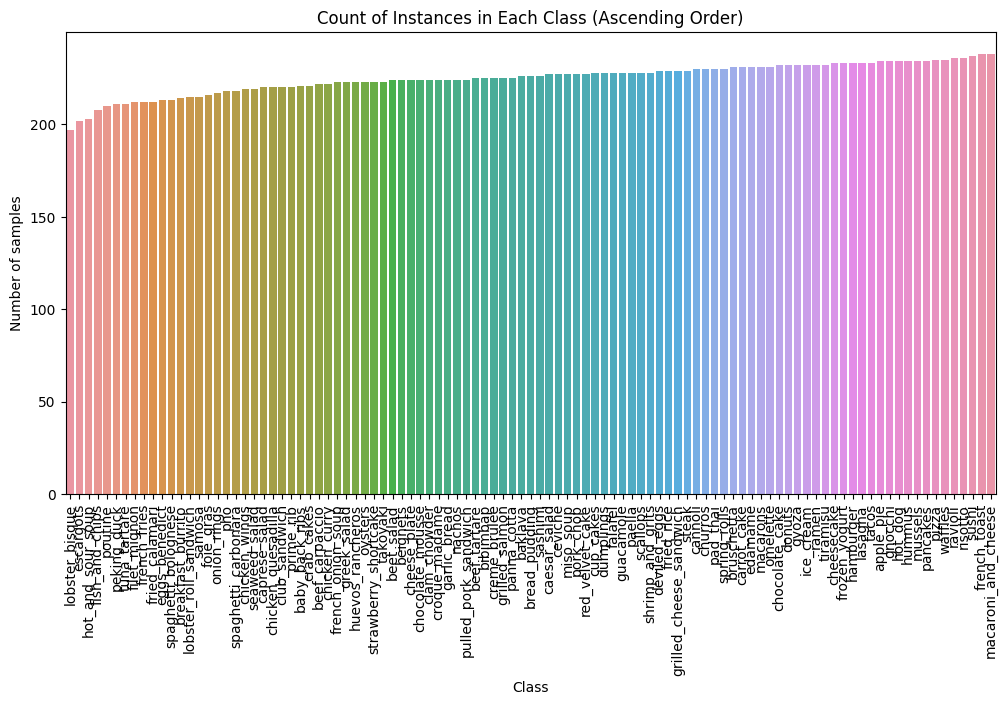

In [28]:
#  Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Sort the class labels and counts in ascending order
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k])
class_labels_sorted = [class_labels[i] for i in sorted_indices]
class_counts_sorted = [class_counts[i] for i in sorted_indices]

# Create a count plot with sorted data
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels_sorted, y=class_counts_sorted)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class (Ascending Order)')
plt.show()

# Validation

In [29]:
resnet.eval()

predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in validation_data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = resnet(images)

        # Get the predicted labels
        _, predicted_label = torch.max(outputs, 1)

        # Store the predicted and true labels
        predicted_labels.extend(predicted_label.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

In [30]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.912264483183659
Precision: 0.912718934554877
Recall: 0.912264483183659
F1-score: 0.9120547540024005


In [31]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       234
           1       0.96      0.95      0.96       221
           2       0.93      0.94      0.94       226
           3       0.80      0.89      0.84       222
           4       0.71      0.68      0.69       225
           5       0.91      0.93      0.92       224
           6       0.86      0.94      0.90       224
           7       0.95      0.88      0.91       225
           8       0.93      0.98      0.95       226
           9       0.93      0.85      0.89       214
          10       0.94      0.94      0.94       231
          11       0.91      0.95      0.93       227
          12       0.95      0.91      0.93       230
          13       0.95      0.95      0.95       220
          14       0.97      0.92      0.94       231
          15       0.95      0.93      0.94       227
          16       0.86      0.77      0.81       224
          17       0.94    

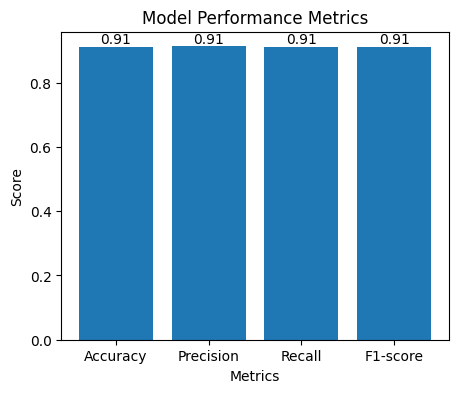

In [32]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

# labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# scores on top of each bar
for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()

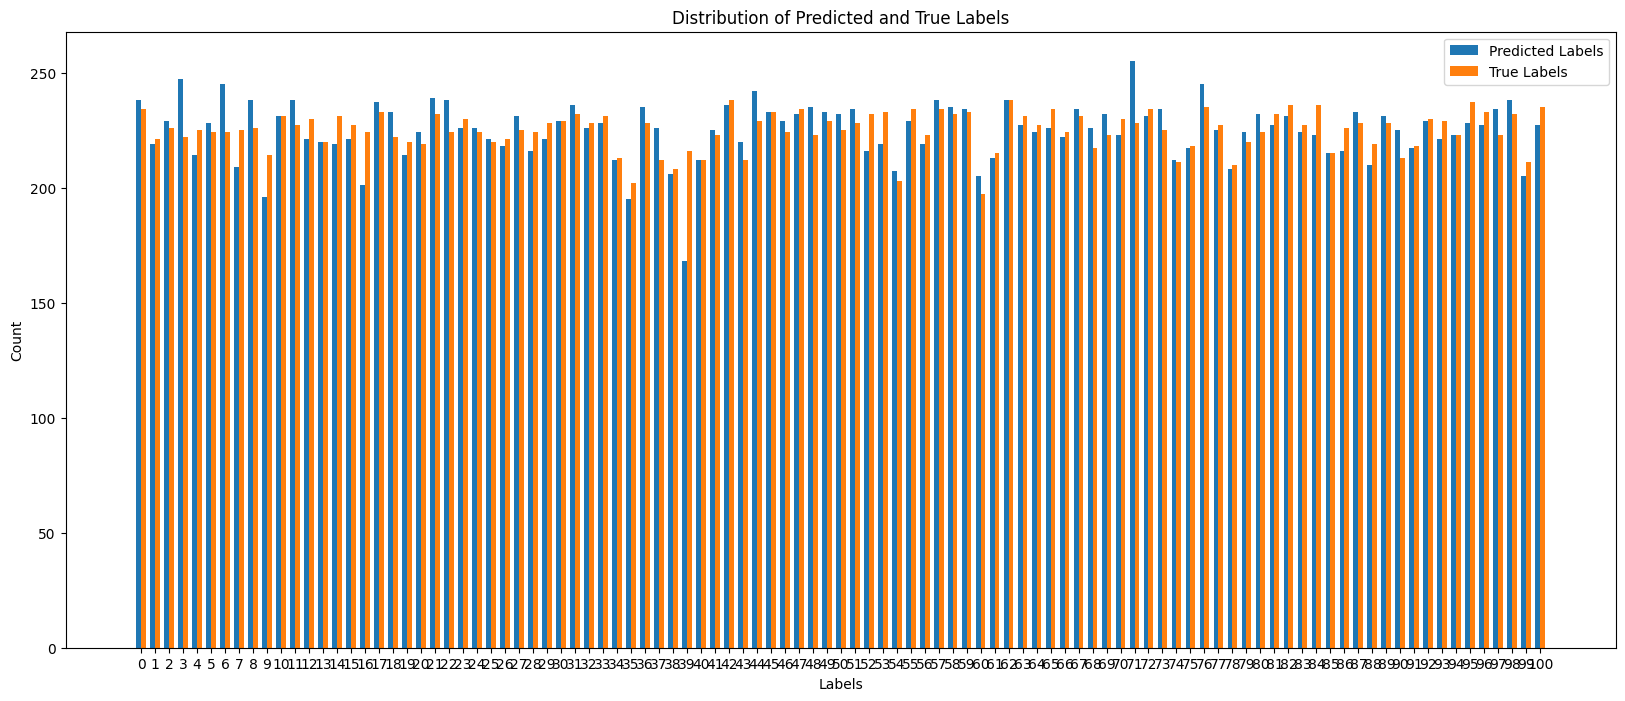

In [33]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_labels)
true_counts = np.bincount(true_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_labels, true_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()